# Procedure for an indirect test of the time-drift effect:
1. Use Sloan Digital Sky Survey (SDSS) SQL Queries to select galaxies within a redshift (z) range 0.15 < z < 0.3. This range is chosen from Morseco (2011), *"Early-type galaxies as probes of galaxy formation and cosmology,"* for its S/N strength using the $D4000_n$ parameter.

2. Collect and label spectrum and feature data for each galaxy. Spectrum data can then be used to:

    * Make data quality cuts based on error values.

    * Characterize galaxy class.

    * Determine if the galaxy has an active galactic nuclei (AGN).

3. Determine the galaxy's morphology. This is used as a control variable to prevent mixing data from populations that evolve differently regardless of environment.

4. Determine the galaxy's local population density within a range of volumes.

5. Create different plots of data with redshift as the independent variable (x-axis) and $D4000_n$ and $H\delta$ as the dependent variables. Split plots by environment (local population density: void/underdense, filament/field, wall/cluster) for different morphologies and SFHs.
6. Investigate **systematic offsets/divergences** between environment classes.

# 1. SQL Query
```
SELECT TOP 10000
p.objid, s.plate, s.mjd, s.fiberid,
dbo.fGetUrlFitsSpectrum(s.specObjID) AS spec_fits_url
FROM PhotoObj AS p
JOIN SpecObj AS s
    ON p.objid = s.bestobjid
WHERE 
    s.class = 'GALAXY'
    AND s.z BETWEEN 0.15 AND 0.3
    AND s.zWarning = 0
```
The RA, DEC, z, zerr, plate, mjd, and fiberid can all be collected from the FITS file, as well as the spectral data required for analysis.

The "TOP 10" specifier can be removed to return all objects in the library in this redshift range. It is being kept here for testing the methods before performing the full data analysis.

This query can then return a CSV file which has as one of its columns a link to a downloadable FITS file. These files can then be downloaded and put into another file as:

In [ ]:
import pandas as pd
import requests
from pathlib import Path
from tqdm import tqdm

# Creating method to download data from the FITS file
def download_data(df):
    # Directory to store FITS files
    outdir = Path('FITS')
    outdir.mkdir(exist_ok=True)
    for _, row in tqdm(df.iterrows(), total=len(df)):
        objid = row['objid']
        plate = row["plate"]
        mjd   = row["mjd"]
        fiber = row["fiberid"]
        url   = row['spec_fits_url']

        filename = f'spec-{plate}-{mjd}-{fiber:04d}.fits'
        filepath = outdir/filename

        if filepath.exists():
            continue # Skip downloaded files

        r = requests.get(url, stream=True)
        r.raise_for_status()

        with open(filepath, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    print('Finished downloading FITS files!')

# Load the test CSV
df = pd.read_csv('Skyserver_SQL12_22_2025 10_54_56 PM.csv', comment='#')
download_data(df)

100%|██████████| 10000/10000 [00:04<00:00, 2448.60it/s]

Finished downloading FITs files!


Extracting from the returned FITS file (spec_fits_url) and converting to rest wavelength using $\lambda_{rest} = \frac{\lambda_{obs}}{(1 + z)}$:

1. Break strength at 4000 $\AA$. Flux from 4000-4100 $\AA$, $F_{red}$ and 3850-3950 $\AA$, $F_{blue}$. $$D4000_n = \frac{F_{red}}{F_{blue}}$$ This value must be calculated from the data.

2. The uncertainty in $D4000_n$, found using the inverse variance of the same flux ranges as $$\sigma(D4000_n)=D4000_n \times \sqrt{(\frac{\sigma F_{red}}{F_{red}})^2 + (\frac{\sigma F_{blue}}{F_{blue}})^2}$$ This value must be calculated from the data.

3. The flux produced by singly-ionized oxygen at a wavelength of 3727 $\AA$, denoted $[O \text{ } _{II}]\lambda3727$.

4. The rest frame equivalent width of this line ($W_0[O \text{ } _{II}]$).

5. The flux of the $H\delta$ Balmer line at 4101 $\AA$.

6. The rest frame equivalent width of this line ($W_0[H\delta]$).

# 2. Collect and label spectrum data for each galaxy

In [11]:
from astropy.io import fits
import numpy as np
# Extract data

def collect_data(file):
    """
    Compute D4000n, collect [OII] 3727 & Hdelta flux/EW from SDSS FITS spectrum file.
    Negative Err values = invalid fit.
    Flux negative for absorption spectra, positive for emission.
    """
    # Open file
    hdul = fits.open(file)
    
    # Assign dfs
    hdu     = hdul[0].header
    coadd   = hdul[1].data
    specobj = hdul[2].data
    spzline = hdul[3].data

    # Info
    ra  = hdu['PLUG_RA']
    dec = hdu['PLUG_DEC']

    # Label data
    plate = spzline['PLATE'][0]
    mjd   = spzline['MJD'][0]
    fiber = spzline['FIBERID'][0]
    objid = f'spec-{plate}-{mjd}-{fiber:04d}'

    # Flux and wavelength
    flux       = coadd['flux']
    loglam     = coadd['loglam']
    lambda_obs = 10**loglam
    ivar       = coadd['ivar']

    # Redshift
    z     = specobj['Z'][0]
    z_err = specobj['Z_ERR'][0]

    # Shift to rest-frame
    lambda_rest = lambda_obs / (1 + z)

    # Find D4000n and uncertainty
    red_mask     = (lambda_rest >= 4000) & (lambda_rest <= 4100)
    blue_mask    = (lambda_rest >= 3850) & (lambda_rest <= 3950)
   
    F_red        = np.mean(flux[red_mask])
    red_flux     = flux[red_mask]
    red_ivar     = ivar[red_mask]

    F_blue       = np.mean(flux[blue_mask])
    blue_flux    = flux[blue_mask]
    blue_ivar    = ivar[blue_mask]

    D4000n       = F_red / F_blue

    # Protect against divisions by zero
    good_red = red_ivar > 0
    good_blue = blue_ivar > 0
    if good_red.sum() == 0 or good_blue.sum() == 0:
        sigma_D4000n = np.inf
    else:    
        sigma_red    = np.sqrt(1 / np.sum(red_ivar[good_red]))
        sigma_blue   = np.sqrt(1 / np.sum(blue_ivar[good_blue]))
        sigma_D4000n = D4000n * np.sqrt(
        (sigma_red / F_red)**2 +
        (sigma_blue / F_blue)**2
    )
    

    # OII 3727 Flux and EW
    oii_mask     = spzline['LINENAME']=='[O_II] 3727'
    oii_flux     = spzline['LINEAREA'][oii_mask][0]
    oii_flux_err = spzline['LINEAREA_ERR'][oii_mask][0]
    oii_EW       = spzline['LINEEW'][oii_mask][0]
    oii_EW_err   = spzline['LINEEW_ERR'][oii_mask][0]

    # H delta Flux and EW
    h_delta_mask     = spzline['LINENAME']=='H_delta'
    h_delta_flux     = spzline['LINEAREA'][h_delta_mask][0]
    h_delta_flux_err = spzline['LINEAREA_ERR'][h_delta_mask][0]
    h_delta_EW       = spzline['LINEEW'][h_delta_mask][0]
    h_delta_EW_err   = spzline['LINEEW_ERR'][h_delta_mask][0]

    # Other lines for AGN
    # OIII 5007, H beta, NII 6583, H alpha
    o_iii_mask   = spzline['LINENAME']=='[O_III] 5007'
    o_iii_flux   = spzline['LINEAREA'][o_iii_mask][0]
    h_beta_mask  = spzline['LINENAME']=='H_beta'
    h_beta_flux  = spzline['LINEAREA'][h_beta_mask][0]
    n_ii_mask    = spzline['LINENAME']=='[N_II] 6583'
    n_ii_flux    = spzline['LINEAREA'][n_ii_mask][0]
    h_alpha_mask = spzline['LINENAME']=='H_alpha'
    h_alpha_flux = spzline['LINEAREA'][h_alpha_mask][0]


    # Creating dictionary to store values
    data_dict = {
        'objid': objid,  
        'ra': ra,
        'dec': dec,                     
        'z': z,                                
        'z_err': z_err,                       
        'D4000n': D4000n, 
        'sigma_D4000n': sigma_D4000n,                    
        'oii_flux': oii_flux,                 
        'oii_flux_err': oii_flux_err,         
        'oii_EW': oii_EW,                     
        'oii_EW_err': oii_EW_err,             
        'h_delta_flux': h_delta_flux,         
        'h_delta_flux_err': h_delta_flux_err, 
        'h_delta_EW': h_delta_EW,             
        'h_delta_EW_err': h_delta_EW_err,
        'o_iii_flux': o_iii_flux,
        'h_beta_flux': h_beta_flux,
        'n_ii_flux': n_ii_flux,
        'h_alpha_flux': h_alpha_flux,    

    }

    # Return dictionary
    return data_dict

data_dict = collect_data('.\FITS\spec-417-51821-0029.fits')
print(data_dict['n_ii_flux'])
    

7.3359365


# 2 (cont). Data quality cuts, galaxy classification.

As discussed previously, data quality cuts will be made at $\sigma(W_0[H\delta]) \ge 0.8 \text{ }\AA$. The data quality cut intended at $\sigma(D4000_n) \ge 0.03$ has proved overly restrictive for this redshift range, so another quality cut will be made based on a signal to noise (S/N) ratio of $\frac{D4000_n}{\sigma(D4000_n)}>5$. $D4000_n$ must also be positive in both bands, so negative values will be labelled as invalid. Equivalent widths (EWs) are used for S/N ratios for $W_0[H\delta]$ and $W_0[O\text{ }II]$. Detections for these bands are defined as $|EW|/EW_{err} \ge 2$, otherwise the line will be considered "Absent."

For characterizing SFH:

* $D4000_n$ tracks long-term, light-weighted (meaning weighted by how much light the stellar population contributes to the spectrum as opposed to mass-weighted) stellar age. Larger values $\to$ older.

* $W_0[H\delta]$ is sensitive to **recent changes** (~0.1-1 Gyr) in star formation. Stronger absorption $\to$ formation stopped or declined more recently.

* $W_0[O \text{ }_{II}]$ relates to recent star formation ($\le 10-50$ Myr).

Following Poggianti et al. (1999), *"The star formation histories of galaxies in distant clusters,"* the EWs can be used to classify the galaxies. The table from Poggianti et al. goes as:

| Class | $W_0[O\text{ }_{II}] \lambda 3727$ ($\AA$) | $W_0[H\delta]$ ($\AA$) | Comments                                                    |
| ---   | :---:                                      | :---:                  | ---                                                         |
|k      |Absent                                      |<3                      |Passive                                                      |
|k+a    |Absent                                      |3-8                     |Moderate Balmer absorption without emission                  |
|a+k    |Absent                                      |$\ge 8$                 |Strong Balmer absorption without emission                    |
|e(c)   |Yes, $\lt 40$                               |$\lt 4$                 |Moderate Balmer absorption plus emission, spiral-like        |
|e(a)   |Yes                                         |$\ge 4$                 |Strong Balmer absorption plus emission                       |
|e(b)   |$\ge 40$                                    |...                     |Starburst                                                    |
|e(n)   |...                                         |...                     |AGN from broad lines or $[O\text{ }_{II}] 5007/H\beta$ ratio |
|e      |Yes                                         |?                       |At least one emission line, but S/N too low to classify      |
|?      |?                                           |?                       |Unclassifiable                                               |

"Absent" here is classified as an EW stronger than -5 $\AA$ (meaning <-5). The "..." entries indicate that the specific spectral index is not used to define the galaxy class. For Active Galactic Nuclei (AGN) objects, as both EWs for [O II] and $H\delta$ are not used, this paper will use the definition of an AGN as given by Kauffmann et al. (2003), *"The Host Galaxies of AGN,"* using instead the [O III], $H\beta$, [N II], and $H\alpha$ lines. By their definition, a galaxy is defined as an AGN if
$$log(\frac{[O\text{ }III]}{H\beta}) > 0.61 [log(\frac{[N\text{ }II]}{H\alpha})-0.05]^{-1}+1.3$$

The letters in the classification denote the dominant spectral types (k $\to$ older K-type stars, a $\to$ A-type stars, e $\to$ emission lines $\to$ ongoing star formation). So:

| Class |Dominant star description                                                                                                       |
|---    | ---                                                                                                                            |
|k      |K-type. Quenched, passively evolving galaxy. No emission lines.                                                                 |
|k+a    |Mainly K-type, some A-type. Recently ended star formation.                                                                      |
|a+k    |Mainly A-type, some K-type. More extreme post-starburst.                                                                        |
|e(c)   |"Continuous." Star-forming galaxy, typical of spirals galaxies.                                                                 |
|e(a)   |Star-forming + strong A-type signature. Recent burst or rapid decline.                                                          |
|e(b)   |"Burst." Ongoing starburst, dominated by younger O/B-type stars.                                                                |
|e(n)   |AGN. Emission does not trace star formation.                                                                                    |
|e      |Emission present but unclassifiable.                                                                                            |
|?      |Data quality too poor to assign class. $\|EW\|/EW_{err} \lt 2$ for both $H\delta$ and $[O\text{ }_{II}]$ and\or $D4000_n \lt 0$ |

Galaxy classes will be assigned following the format of Poggianti et al. (1999). ? is reserved for galaxies which fail the quality cuts.

For the purposes of this thesis, galaxy classification will be used to relate the local population density of the galaxy to the type of galaxy. If a disproportionate number of k-type galaxies are in voids and a disproportionate number of e(c), e(b), and/or e(a) galaxies are in clusters, these results would be in favor of timescape cosmology.

In [ ]:
def sort_galaxy(data_dict):
    """
    Use spectrum values to determine the galaxy's spectral class.
    """
    # Assign variables
    h_delta_EW     = data_dict['h_delta_EW']
    h_delta_EW_err = data_dict['h_delta_EW_err']
    oii_EW         = data_dict['oii_EW']
    oii_EW_err     = data_dict['oii_EW_err']
    D4000n         = data_dict['D4000n']
    sigma_D4000n   = data_dict['sigma_D4000n']
    o_iii          = data_dict['o_iii_flux']
    h_beta         = data_dict['h_beta_flux']
    n_ii           = data_dict['n_ii_flux']
    h_alpha        = data_dict['h_alpha_flux']

    # Quality cuts
    if (h_delta_EW_err < 0) or (oii_EW_err < 0):
        return '?: Invalid EW value'
    elif  (D4000n / sigma_D4000n) < 2:
        return '?: D4000n quality cut'
    elif (h_delta_EW_err >= 0.8):
        return '?: H delta quality cut'
    
    # AGN before other classes
    # Avoiding division by zero/require positive values
    if (o_iii > 0) and (h_beta > 0) and (n_ii > 0) and (h_alpha > 0):

        x = np.log10(n_ii/h_alpha)
        y = np.log10(o_iii/h_beta)
        # Guard against vertical asymptote
        if not np.isclose(x - 0.05, 0.0):
            if y > (0.61 / (x - 0.05) + 1.3):
                return 'e(n)'
    
    # OII W_0 "Absent"
    if (oii_EW < -5):
        if h_delta_EW < 3:
            return 'k'
        elif (3 < h_delta_EW < 8):
            return 'k+a'
        elif h_delta_EW >= 8:
            return 'a+k'
        
    # OII EW present
    elif (oii_EW > -5):
        if (oii_EW < 40) and (h_delta_EW < 4):
            return 'e(c)'
        elif (oii_EW >= 40):
            return 'e(b)'
        elif h_delta_EW >=4:
            return 'e(a)'
        else:
            return 'e'

The following code cell is where the data sorting takes place. First, it is necessary to create a function that can count the number of galaxies around a chosen object at different radii (2, 5, 10, and 15 Mpc) by performing a new SDSS SQL query. To do this requires using the relationship between the angular diameter, $\theta$, in units of radians, the distance from the object, $d_A$, and the length of the object, $x$. This is the **angular diameter distance**, and can be found as 
$$d_A = \frac{x}{\theta}$$
This relationship becomes complicated under $\Lambda \text{CDM}$ at redshifts greater than about 1.5, at which point objects begin to appear larger with increasing redshift, but this domain is unimportant for redshift range being investigated. Under an assumption of Euclidean geometry, the relationship between size and distance is 
$$tan(\theta)=\frac{x}{d_A}$$

The astropy.cosmology package for Python is able to convert any given redshift value to a distance value (using an assumption of $\Lambda \text{CDM}$ cosmology), so a simple function can be written to use that value as an input along with a chosen radius value to determine the search radius for the SQL query.

This however creates a search cone - returning objects which are **visually** nearby the galaxy in the sky but may be arbitrarily close or far away from the galaxy in physical space. To select only the objects which are physically relevant to the chosen galaxy means also ensuring that objects are within a given redshift related to the search radius. Along the line of sight, distances relate to redshift via the comoving radial distance $\Chi$ as: 
$$\frac{d\Chi}{dz} = \frac{c}{H(z)}$$
Meaning for a small distance $\Delta\Chi$: 
$$\Delta z \approx \frac{\Delta\Chi}{d\Chi/dz}=\Delta\Chi \frac{H(z)}{c}$$
Where $H(z)$ is the Hubble parameter at redshift $z$, and $c$ is the speed of light. It then is necessary to convert the physical distance (the search radius) to the comoving distance before using this result to find the $\pm z$ value that will narrow the search window. This can be done using the relationship 
$$R_{comoving}=R_{physical}(1+z)$$
The query then only needs to use the calculated values to count the number of objects in the search window within a redshift range before collecting the values for later use. 


In [93]:
from pathlib import Path
from collections import Counter, defaultdict
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u
import astropy.constants as const
from astroquery.sdss import SDSS


def physical_to_angular_radius(z, mpc_radius):
    """
    Convert a physical radius (Mpc) at a given redshift to an angular radius in arcminutes.
    """
    # Convert z to Mpc
    distance        = cosmo.angular_diameter_distance(z)
    # Calculate theta
    theta           = np.arctan((mpc_radius * u.Mpc) / distance)
    radius_arcmin   = theta.to(u.arcmin).value
    return radius_arcmin

def physical_to_delta_z(z, mpc_radius):
    """
    Convert a physical line-of-sight distance (Mpc) into a redshift half-width.
    """
    # Convert physical to comoving distance
    r_comoving = mpc_radius * (1 + z) * u.Mpc

    # Hubble parameter at redshift z
    Hz = cosmo.H(z) # km / s / Mpc

    # Convert H(z)/c to 1/distance units
    c = const.c.to(u.km/u.s)
    delta_z = ((Hz / c) * r_comoving).decompose()

    return delta_z.value


def build_sdss_neighbor_count_query(data_dict, search_radius_mpc):
    """
    Builds an SDSS SQL query that counts galaxies within a physical radius around a target galaxy.

    Returns SQL query string for SDSS CasJobs
    """
    ra = data_dict['ra']
    dec = data_dict['dec']
    z = data_dict['z']
    dz = physical_to_delta_z(data_dict['z'], search_radius_mpc)
    z_min = z - dz
    z_max = z + dz

    radius_arcmin = physical_to_angular_radius(z, search_radius_mpc)

    sql_query = f"""
SELECT COUNT(*) AS neighbor_count
FROM SpecObj as g
WHERE dbo.fDistanceEq(g.ra, g.dec, {ra}, {dec}) < {radius_arcmin}
    AND g.z BETWEEN {z_min} AND {z_max}
    """
    return sql_query

def count_sdss_neighbors(data_dict, search_radius_mpc):
    """
    Query SDSS and return the number of neighboring galaxies within a physical radius
    """
    sql = build_sdss_neighbor_count_query(data_dict, search_radius_mpc)
    result = SDSS.query_sql(sql)
    if result[0][0] is None or 0:
        return 0
    return result[0][0]

def sort_values(folder):
    # Store values by class
    class_sort = defaultdict(list)

    # Count different galaxy classes
    counts = Counter()

    # Radii to calculate neighbors for
    radii_mpc = [2, 5, 10, 15]

    # Collect values
    for file in folder.iterdir():
        data_dict = collect_data(file)
        galaxy_class = sort_galaxy(data_dict)

        # Calcuate neighbor counts for each radius
        try:
            n_neighbors = {r: count_sdss_neighbors(data_dict, r) for r in radii_mpc}
        except Exception as e:
            print(f"Error for {data_dict['objid']}:\n {e}")
            n_neighbors = None

        # Store all relevant data in class_sorts object
        class_sort[galaxy_class].append(
            {
                'z': data_dict['z'], 
                'D4000n': data_dict['D4000n'], 
                'sigma_D4000n': data_dict['sigma_D4000n'],
                'h_delta_EW': data_dict['h_delta_EW'], 
                'h_delta_EW_err': data_dict['h_delta_EW_err'],
                'oii_EW': data_dict['oii_EW'],
                'n_neighbors': n_neighbors
            }
        )
        counts[galaxy_class] += 1
    print(counts)

    return class_sort

folder = Path('FITS')
class_sort = sort_values(folder)

Error for spec-5743-56011-0866:
 Number of header columns (1) inconsistent with data columns in data line 9
Counter({'e(c)': 4151, '?: H delta quality cut': 3209, 'e(n)': 1380, '?: Invalid EW value': 633, 'k': 598, 'e(b)': 15, '?: D4000n quality cut': 8, 'e(a)': 6})


In [ ]:
# Saving the data to avoid running above cell multiple times
import pickle
with open('class_sort.pkl', 'wb') as f:
    pickle.dump(class_sort, f)

In [3]:
# Opening the data saved by previous cell on repeated uses
import pickle
with open('class_sort.pkl', 'rb') as f:
    class_sort = pickle.load(f)

In [105]:
import numpy as np

def report_values_by_class(class_sort, radii=(2,5,10,15)):
    num_classes = []
    total = sum(len(galaxies) for galaxies in class_sort.values())
    for galaxy_class, galaxies in class_sort.items():
        if '?' in galaxy_class:
            continue

        print(f'{galaxy_class} type galaxies:')

        for radius in radii:
            vals = []

            for g in galaxies:
                nnb = g.get('n_neighbors')
                if not nnb:
                    continue
                if radius not in nnb:
                    continue
                vals.append(nnb[radius])

            if len(vals) == 0:
                print(f'  r = {radius} Mpc: no data')
                continue

            vals = np.array(vals)
            print(f'  r = {radius} Mpc: Mean num neighbors = {vals.mean():.2f}, Min = {vals.min():.0f}, Max = {vals.max():.0f}')
        print(f'Number of {galaxy_class} type galaxies in sample: {len(vals)}')
        num_classes.append(len(vals))

        print()
    counted = sum(num_classes)
    print(f'Total counted galaxies: {counted} out of {total}.\n{total-counted} or {((total-counted)/total)*100:.2f}% of galaxies were rejected by quality cuts.')

report_values_by_class(class_sort)

e(n) type galaxies:
  r = 2 Mpc: Mean num neighbors = 1.44, Min = 1, Max = 8
  r = 5 Mpc: Mean num neighbors = 3.92, Min = 1, Max = 40
  r = 10 Mpc: Mean num neighbors = 13.19, Min = 1, Max = 91
  r = 15 Mpc: Mean num neighbors = 30.78, Min = 1, Max = 197
Number of e(n) type galaxies in sample: 1380

e(c) type galaxies:
  r = 2 Mpc: Mean num neighbors = 1.53, Min = 1, Max = 8
  r = 5 Mpc: Mean num neighbors = 4.24, Min = 1, Max = 41
  r = 10 Mpc: Mean num neighbors = 14.05, Min = 1, Max = 112
  r = 15 Mpc: Mean num neighbors = 31.63, Min = 1, Max = 208
Number of e(c) type galaxies in sample: 4150

k type galaxies:
  r = 2 Mpc: Mean num neighbors = 1.50, Min = 1, Max = 8
  r = 5 Mpc: Mean num neighbors = 3.85, Min = 1, Max = 30
  r = 10 Mpc: Mean num neighbors = 11.77, Min = 1, Max = 93
  r = 15 Mpc: Mean num neighbors = 25.37, Min = 2, Max = 157
Number of k type galaxies in sample: 598

e(a) type galaxies:
  r = 2 Mpc: Mean num neighbors = 1.17, Min = 1, Max = 2
  r = 5 Mpc: Mean num n

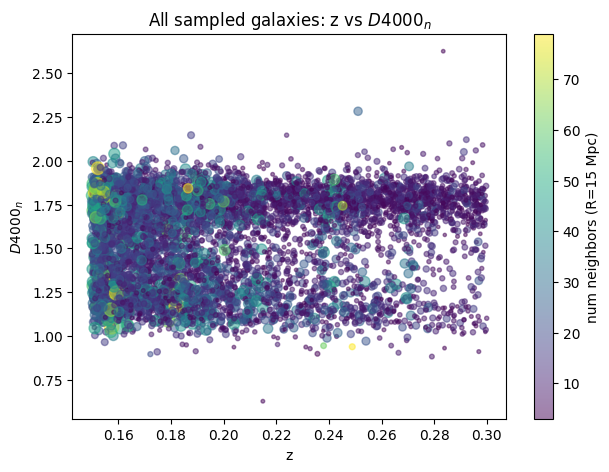

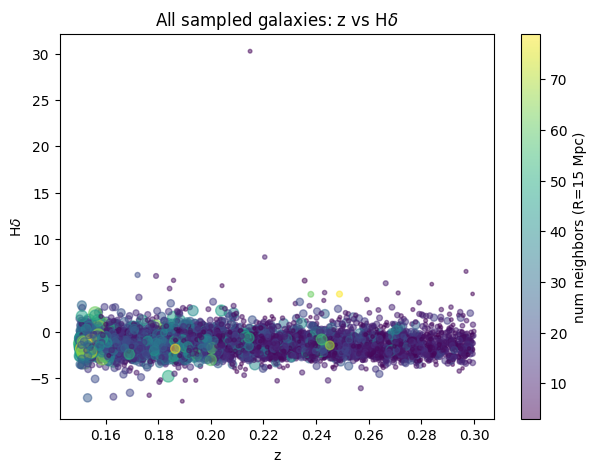

In [106]:
import matplotlib.pyplot as plt
import numpy as np

def plot_all_classes(radius, class_sort):
    # Extract flattened arrays per class
    flat = {}
    for galaxy_class, galaxies in class_sort.items():
        # Flatten class_sort into lists
        z_vals           = []
        D4000n_vals      = []
        n_neighbors_vals = []
        h_delta_vals     = []
        oii_vals         = []

        for g in galaxies:
            nnb = g.get('n_neighbors')
            # Skip galaxies without neighbor info
            if nnb is None:
                continue
            if radius not in nnb:
                return 'Radius chosen was not sampled. Choose from [2, 5, 10, 15]'
            
            z_vals.append(g['z'])
            D4000n_vals.append(g['D4000n'])
            n_neighbors_vals.append(g['n_neighbors'][radius])
            h_delta_vals.append(g['h_delta_EW'])
            oii_vals.append(g['oii_EW'])
        if len(z_vals) > 0 and '?' not in galaxy_class:
            flat[galaxy_class] = {
                'z': np.array(z_vals),
                'D4000n': np.array(D4000n_vals),
                'nnb': np.array(n_neighbors_vals),
                'h_delta': np.array(h_delta_vals),
                'oii': np.array(oii_vals)
            }
    # Plot 1: z vs D4000n (all classes)
    plt.figure(figsize=(7,5))
    for cls, data in flat.items():
        sizes = 5 + data['nnb']/2
        plt.scatter(data['z'], data['D4000n'], c=data['nnb'], s=sizes, alpha=0.5)
    plt.xlabel('z')
    plt.ylabel(r'$D4000_n$')
    plt.colorbar(label=f'num neighbors (R={radius} Mpc)')
    plt.title(r'All sampled galaxies: z vs $D4000_n$')
    plt.show()

    plt.figure(figsize=(7,5))
    for cls, data in flat.items():
        sizes = 5 + data['nnb']/2
        plt.scatter(data['z'], data['h_delta'], c=data['nnb'], s=sizes, alpha=0.5)
    plt.xlabel('z')
    plt.ylabel(r'H$\delta$')
    plt.colorbar(label=f'num neighbors (R={radius} Mpc)')
    plt.title(r'All sampled galaxies: z vs H$\delta$')
    plt.show()
            
plot_all_classes(15, class_sort)